## Data Generation

In [66]:
import pandas as pd
import numpy as np
from faker import Faker

fake = Faker()
num_records = 1000

# Generate synthetic healthcare billing data
data = {
    "patient_id": [fake.unique.random_int(min=1000, max=9999) for _ in range(num_records)],
    "service_date": [fake.date_between(start_date='-1y', end_date='today') for _ in range(num_records)],
    "service_type": [fake.random_element(elements=("Consultation", "Lab Test", "Therapy", "Procedure")) for _ in range(num_records)],
    "billed_amount": np.random.uniform(100, 1000, num_records).round(2),
    "invoiced_amount": np.random.uniform(80, 900, num_records).round(2),
    "insurance_adjustment": np.random.uniform(0, 100, num_records).round(2),
    "payment_status": [fake.random_element(elements=("Paid", "Pending", "Denied")) for _ in range(num_records)]
}

df = pd.DataFrame(data)
df.head()


,patient_id,service_date,service_type,billed_amount,invoiced_amount,insurance_adjustment,payment_status
0,7859,2024-10-03,Procedure,558.95,324.92,35.20,Pending
1,2229,2025-01-27,Procedure,778.93,335.71,77.21,Denied
2,6150,2025-01-31,Consultation,701.44,531.64,85.75,Paid
3,1513,2024-02-25,Therapy,447.06,278.02,33.36,Pending
4,7066,2024-05-21,Therapy,833.81,91.19,50.87,Paid


## Data Processing and Cleaning

In [69]:
# Convert service_date to datetime and sort data
df['service_date'] = pd.to_datetime(df['service_date'])
df = df.sort_values('service_date')

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# remove rows
df = df.dropna()

# Validate data types
print(df.dtypes)


Missing values:
 patient_id              0
service_date            0
service_type            0
billed_amount           0
invoiced_amount         0
insurance_adjustment    0
payment_status          0
dtype: int64
patient_id                       int64
service_date            datetime64[ns]
service_type                    object
billed_amount                  float64
invoiced_amount                float64
insurance_adjustment           float64
payment_status                  object
dtype: object


## State Reporting File Generation

In [72]:
# Aggregate invoiced amounts by service_date
report_df = df.groupby('service_date')['invoiced_amount'].sum().reset_index()
report_df.columns = ['Service Date', 'Total Invoiced Amount']

# Save report to CSV with two decimal places formatting
report_df.to_csv('state_reporting.csv', index=False, float_format='%.2f')
print("State reporting file generated: state_reporting.csv")


State reporting file generated: state_reporting.csv


## Simulating Journal Entries & Invoicing

In [75]:
# Simulate journal entries: calculate total revenue and adjustments
journal_entries = df.groupby('service_date').agg({
    'invoiced_amount': 'sum',
    'insurance_adjustment': 'sum'
}).reset_index()

journal_entries['net_revenue'] = journal_entries['invoiced_amount'] - journal_entries['insurance_adjustment']

# Save to CSV with 2 decimal formatting for all numeric columns
journal_entries.to_csv('journal_entries.csv', index=False, float_format='%.2f')
print("Journal entries file generated: journal_entries.csv")

Journal entries file generated: journal_entries.csv


## SQL Integration Using SQLite

In [78]:
import sqlite3

# Create SQLite database in memory and load data
conn = sqlite3.connect(':memory:')
df.to_sql('billing', conn, index=False, if_exists='replace')

# Run SQL query to aggregate invoiced amounts by service type
query = """
SELECT service_type, SUM(invoiced_amount) as Total_Invoiced
FROM billing
GROUP BY service_type
ORDER BY Total_Invoiced DESC
"""
sql_report = pd.read_sql_query(query, conn)
print(sql_report)


   service_type  Total_Invoiced
0       Therapy       123815.44
1     Procedure       121649.74
2  Consultation       119881.09
3      Lab Test       115404.84


## Data Visualization

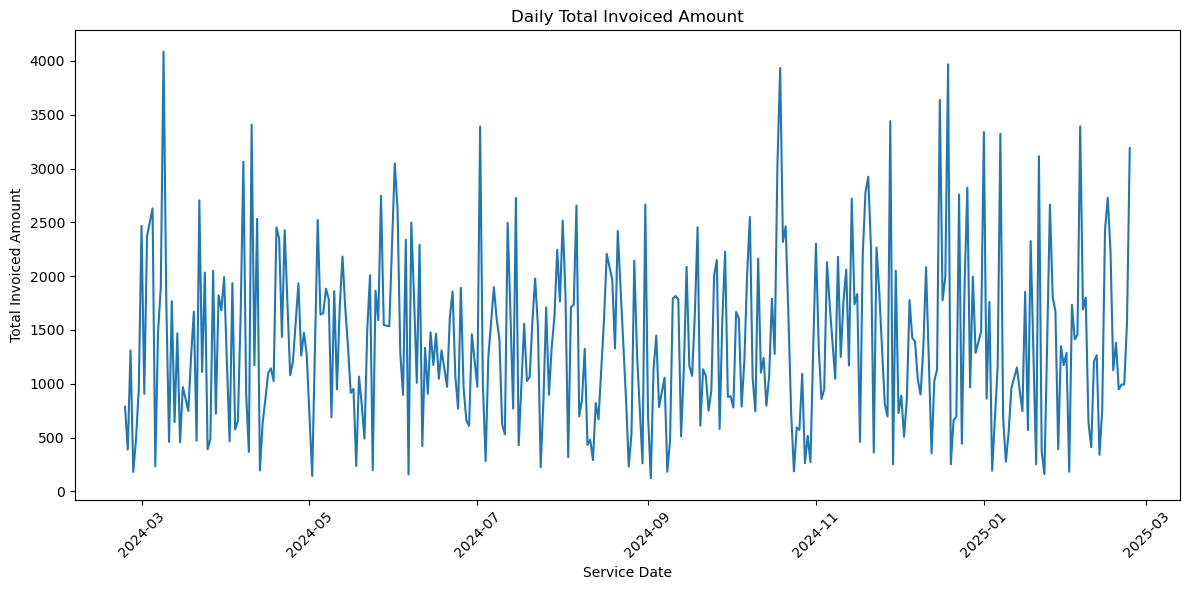

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot total invoiced amount over time
plt.figure(figsize=(12,6))
sns.lineplot(data=report_df, x='Service Date', y='Total Invoiced Amount')
plt.title('Daily Total Invoiced Amount')
plt.xlabel('Service Date')
plt.ylabel('Total Invoiced Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Error Handling and Validation

In [84]:
try:
    # Attempt to group data
    report_df = df.groupby('service_date')['invoiced_amount'].sum().reset_index()
    report_df.columns = ['Service Date', 'Total Invoiced Amount']
except Exception as e:
    print("Error during aggregation:", e)

# Validate output
if report_df.empty:
    print("Warning: The report is empty. Check data input.")
else:
    print("Report generated successfully.")


Report generated successfully.
